### Considered model: four-bar linkage (= two link manipulator + one link manipulator + rigid coupling)


This Notebook depends on symbtools >=0.2.5

→ `pip install --upgrade symbtools`





In [1]:
%load_ext ipydex.displaytools
%matplotlib inline

import sys
# to load assimulo under wsl2
sys.path.append('/home/kwrede/miniconda3/lib/python3.8/site-packages')
sys.path.append('/home/wredi/miniconda3/lib/python3.8/site-packages')

import os
import pickle

import sympy as sp
import numpy as npy  # we need `np` later 
from sympy import sin, cos, pi
from sympy.interactive import printing

# using wredsen's symbtools fork (https://github.com/wredsen/symbtools @ DAE_statefeedback), assuming repos SA-Wrede and symbtools share the same parent directory
sys.path.append('../../symbtools/')
import symbtools as st
import symbtools.modeltools as mt
from symbtools.modeltools import Rz # Rotationsmatrix in the xy plane (c, -s; s, c)

import scipy as sc
import scipy.integrate as sc_integrate
from scipy.optimize import fmin
import matplotlib.pyplot as pl
from assimulo.solvers import ODASSL as SOLVER # Imports the solver ODASSL from Assimulo
from assimulo.problem import Overdetermined_Problem # Imports the problem formulation from Assimulo
import ipydex
plt = pl

printing.init_printing(1)

Could not find No module named 'assimulo.solvers.sundials'
Could not find No module named 'assimulo.solvers.kinsol'
/home/wredi/.local/lib/python3.8/site-packages/assimulo/solvers/odepack.py:701: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  N.array([[0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.],  # 5th order
Could not find GLIMDA.


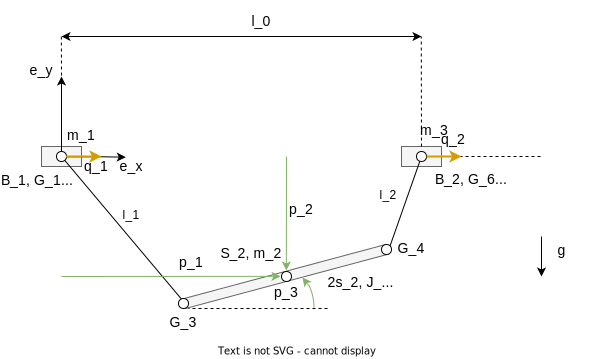

In [2]:
from IPython.display import Image
from IPython.core.display import SVG
SVG(filename='ODE_flatness_analysis_simulation_diagram.svg')

In [3]:
t = sp.Symbol('t')  # time variable

# coordinates
np = 3 # number of passive coordinates (not directly actuated)
nq = 2 # number of actuated coordinates
n = np + nq

pp = st.symb_vector("p1:{0}".format(np+1)) # vector of passive coordinates
qq = st.symb_vector("q1:{0}".format(nq+1)) # vector of actuated coordinates



# vector of control inputs
aa = st.symb_vector("a1:{0}".format(4+1)) ##:T
# vector of all coordinates
ttheta = st.row_stack(pp, qq) ##:T
# vector of velocities 
tthetad = st.time_deriv(ttheta, ttheta) ##:T
# vector of accelerations
tthetadd = st.time_deriv(ttheta, ttheta, order=2) ##:T
tthetaddd = st.time_deriv(ttheta, ttheta, order=3) ##:T
tthetadddd = st.time_deriv(ttheta, ttheta, order=4) ##:T

st.make_global(ttheta, tthetad, tthetadd, tthetaddd, tthetadddd)

# define symbols for measured states
p_meas = st.symb_vector("pm1:{0}".format(3+1)) # error vector of passive coordinates
q_meas = st.symb_vector("qm1:{0}".format(2+1)) # error vector of actuated coordinates

meas_states = st.row_stack(p_meas, q_meas) ##:T
meas_states_d = st.time_deriv(meas_states, meas_states) ##:T

st.make_global(meas_states, meas_states_d)

# define symbols for reference trajectory states
p_ref = st.symb_vector("pr1:{0}".format(3+1)) # error vector of passive coordinates
q_ref = st.symb_vector("qr1:{0}".format(2+1)) # error vector of actuated coordinates

ref_states = st.row_stack(p_ref, q_ref)
ref_states_d = st.time_deriv(ref_states, ref_states)
ref_states_dd = st.time_deriv(ref_states, ref_states, order=2)
ref_states_ddd = st.time_deriv(ref_states, ref_states, order=3)
ref_states_dddd = st.time_deriv(ref_states, ref_states, order=4)

st.make_global(ref_states, ref_states_d, ref_states_dd, ref_states_ddd, ref_states_dddd)

QQ = st.symb_vector("Q1:{0}".format(n+1)) ##:T # vector of generalized foces
st.make_global(QQ)

---

---

---

---

---

---

---

---

---

In [4]:
# symbols for analytic equations
params = sp.symbols('s2, m1, m2, m3, J1, J2, J3, mc1b, mc2b d1, d4, l0, l1, l2, l3, g')
st.make_global(params)

# symbols for control inputs
# ttau = sp.symbols('tau')
tau1, tau2, tau3, tau4 = ttau = st.symb_vector("tau1, tau2, tau3, tau4")

Specify the geometry (joints G and centers of masses S)

---

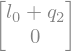

---

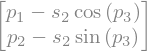

---

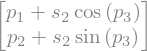

---

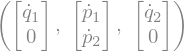

---

In [5]:
# unit vectors
ex = sp.Matrix([1, 0])
ey = sp.Matrix([0, 1])

# basis 1 and 2 (cart positions)
S1 = G1 = B1 = sp.Matrix([q1, 0]) ##:
S3 = G6 = B2 = sp.Matrix([l0 + q2, 0]) ##:

# center of gravity of load
S2 = sp.Matrix([p1, p2])

# suspension points of load
G3 = S2 - Rz(p3)*ex*s2 ##:
G4 = S2 + Rz(p3)*ex*s2 ##:

# Time derivatives of centers of masses
Sd1, Sd2, Sd3 = st.col_split(st.time_deriv(st.col_stack(S1, S2, S3), ttheta)) ##:

# rope vectors
rope1 = (G3 - S1)
rope2 = (G4 - S3)

# Initial values

In [6]:
# load model etc. from pickle of flatness analysis notebook
with open("flatness_analysis_control.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [7]:
# load model etc. from pickle of flatness analysis notebook
with open("qstat_expr.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [8]:
qstat_tau2.co

In [9]:
sys_params = list(dict(J2=0.004553475, g=9.81, l0=0.3, m1=0.45, m2=0.557, m3=0.45, s2=0.15).items()) ##:

sys_params := [('J2', 0.004553475),
 ('g', 9.81),
 ('l0', 0.3),
 ('m1', 0.45),
 ('m2', 0.557),
 ('m3', 0.45),
 ('s2', 0.15)]

---

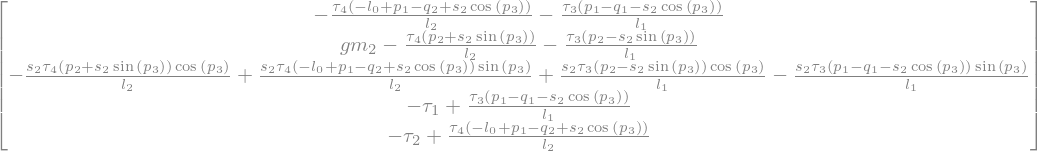

In [10]:
eqns.subz0(tthetadd)

In [11]:
# load DAE constraints and joints for initial value plot from DAE_double_crane_w3_angles notebook
with open("../double_crane_notebooks/DAE_cartesian_initial_values.pcl", "rb") as pfile:
    data = pickle.load(pfile)
    locals().update(data)

In [12]:
# numerical functions for joints and constraints
constraints_func = sp.lambdify(ttheta_cart, constraints, modules="numpy")
joints_func = sp.lambdify(ttheta_cart, joints, modules="numpy")

# cost function of constraints, theta_var: variable coordinates to be optimized, theta_const: constant coordinate (manipulated by slider later)
def constraint_cost(theta_var, theta_const):   
    err = constraints_func(theta_const[0], *theta_var, theta_const[1], theta_const[2])
    return err[0]**2 + err[1]**2 + err[2]**2 # squared error

In [13]:
%matplotlib inline

ttheta0_cart = []
ttheta0 = []

from ipywidgets import interact
@interact(p1_cart=(-1, 1.5, .1), q1=(-1, 1, .1), q2=(-1, 1, .1))
def plot_func(p1_cart, q1, q2):
    res = fmin(constraint_cost, x0=[-0.4, 0.5, -0.4], args=([p1_cart, q1, q2],), disp=0, ftol=1e-15)

    # dependent coordinates
    p2_cart, p3_cart, p4_cart = res
    jc = joint_coords = joints_func(p1_cart, p2_cart, p3_cart, p4_cart, q1, q2)

    plt.plot(jc[0, :], jc[1, :], "ok", ms=7)
    plt.plot(jc[0, :], jc[1, :], "b-")
    plt.axis("equal")
    plt.axis([-0.5, 1.4, -1.5, 0.5])
    
    ttheta0_cart[:] = [p1_cart, p2_cart, p3_cart, p4_cart, q1, q2]
    const_err = constraints_func(*ttheta0_cart)
    
    p1 = p1_cart + 0.5*(p3_cart - p1_cart)
    p2 = p2_cart + 0.5*(p4_cart - p2_cart)
    p3 = npy.arctan2(p4_cart-p2_cart, p3_cart-p1_cart)
    
    ttheta0[:] = [p1, p2, p3, q1, q2]
    
    str_coords = ( f'Initial Values:\n'
                   f'p1: {p1}\n'
                   f'p2: {p2}\n'
                   f'p3: {p3}\n'
                   f'q1: {q1}\n'
                   f'q2: {q2}\n'
                   f'error of constraints: \n {const_err} \n')
    print(str_coords)

interactive(children=(FloatSlider(value=0.20000000000000018, description='p1_cart', max=1.5, min=-1.0), FloatS…

In [61]:
ttheta0

array([ 1.49999995e-01, -4.00000004e-01,  4.43002187e-08,  0.00000000e+00,  0.00000000e+00])

---

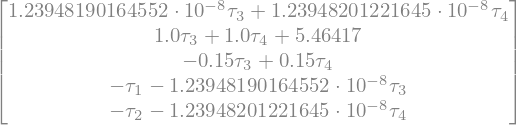

---

In [62]:
eqlbr_conditions = [(p1, ttheta0[0]), (p2, ttheta0[1]), (p3, ttheta0[2]), (q1, ttheta0[3]), (q2, ttheta0[4])] ##:

res = ((mod.eqns.subz0(tthetadd)).subs(eqlbr_conditions)).subs(sys_params) ##:

In [63]:
symbs = list(res.s) ##:
# do not use first equation of res as it adds redundancy (5 eqs for 4 quantities of tau)
sol = sp.solve(res[1:], symbs, dict=True) ##:

---

---

In [64]:
ttheta0 = st.to_np(ttheta.subs(eqlbr_conditions).subs(sol[0])).squeeze() ##:

uu0 = st.to_np(ttau.subs(eqlbr_conditions).subs(sol[0])).squeeze()##:

ttheta0 := array([ 1.49999995e-01, -4.00000004e-01,  4.43002187e-08,  0.00000000e+00,  0.00000000e+00])

---

uu0 := array([ 3.38636991e-08,  3.38637021e-08, -2.73208500e+00, -2.73208500e+00])

---

# Trajectory planning
The parametrization of $\tau_2$ determines the highest required order $N_i$ of the flat output's derivatives. For each component of the flat output a trajectory $y_i$ can be chosen with a polynomial order of $\alpha_i = 2 N_i + 1$ in compliance with the system's initial values.

---

---

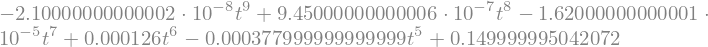

---

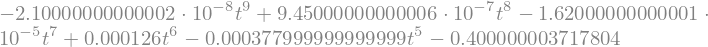

---

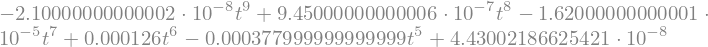

---

---

In [65]:
T0, T1 = 0, 10
p10, p20, p30, q10 = ttheta0[:-1] ##:
p1e, p2e, p3e, q1e = ttheta0[:-1] - 0.3 ##:
# p10 = p10 + 0.2
# p20 = p20 + 0.15
# q10 = q10 + 0.15
# p30 = p30 + 0.1
# polynoms of order 9 (boundary conditions until 4th derivative due to usage of qddot2 later) for p_i
p1_traj = st.condition_poly(t, (T0, p10, 0, 0, 0, 0), (T1, p1e, 0, 0, 0, 0)) ##:
p2_traj = st.condition_poly(t, (T0, p20, 0, 0, 0, 0), (T1, p2e, 0, 0, 0, 0)) ##:
p3_traj = st.condition_poly(t, (T0, p30, 0, 0, 0, 0), (T1, p3e, 0, 0, 0, 0)) ##:
# polynoms of order 5 (boundary conditions until 2nd derivative) for q_1
q1_traj = st.condition_poly(t, (T0, q10, 0, 0), (T1, q1e, 0, 0)) ##:
# trajectory for q2 from flatness relations 
q2_traj = flat_q2.subz([p1, p2, p3, pddot1, pddot2, pddot3, q1], [p1_traj, p2_traj, p3_traj, p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj])
q2_traj = q2_traj.subs(sys_params)

Substitution of $\mathbf{y}$ with trajectories into control inputs

In [66]:
flat_quantities = [pr1, pr2, pr3, qr1, qr2,
                   prdot1, prdot2, prdot3, qrdot1, qrdot2,
                   prddot1, prddot2, prddot3, qrddot1, qrddot2,
                   prdddot1, prdddot2, prdddot3, 
                   prddddot1, prddddot2, prddddot3]

flat_quantities_wo_r = [p1, p2, p3, q1, q2,
                       pdot1, pdot2, pdot3, qdot1, qdot2,
                       pddot1, pddot2, pddot3, qddot1, qddot2,
                       pdddot1, pdddot2, pdddot3, 
                       pddddot1, pddddot2, pddddot3]

flat_quant_subs = [p1_traj, p2_traj, p3_traj, q1_traj, q2_traj,
                   p1_traj.diff(t), p2_traj.diff(t), p3_traj.diff(t), q1_traj.diff(t), q2_traj.diff(t),
                   p1_traj.diff(t, 2), p2_traj.diff(t, 2), p3_traj.diff(t, 2), q1_traj.diff(t, 2), q2_traj.diff(t, 2),
                   p1_traj.diff(t, 3), p2_traj.diff(t, 3), p3_traj.diff(t, 3),
                   p1_traj.diff(t, 4), p2_traj.diff(t, 4), p3_traj.diff(t, 4)]

In [67]:
%%time

tau1_traj = qstat_tau1.subz(flat_quantities, flat_quant_subs)
tau2_traj = qstat_tau2.subz(flat_quantities, flat_quant_subs)
tau3_traj = qstat_tau3.subz(flat_quantities, flat_quant_subs)
tau4_traj = qstat_tau4.subz(flat_quantities, flat_quant_subs)


tau1_backup = flat_tau1_control.subz(flat_quantities, flat_quant_subs)
tau2_backup = flat_tau2_control.subz(flat_quantities, flat_quant_subs)
tau3_backup = flat_tau3_control.subz(flat_quantities, flat_quant_subs)
tau4_backup = flat_tau4_control.subz(flat_quantities, flat_quant_subs)

'''
tau1_feedforward = flat_tau1.subz(flat_quantities_wo_r, flat_quant_subs)
tau2_feedforward = flat_tau2.subz(flat_quantities_wo_r, flat_quant_subs)
tau3_feedforward = flat_tau3.subz(flat_quantities_wo_r, flat_quant_subs)
tau4_feedforward = flat_tau4.subz(flat_quantities_wo_r, flat_quant_subs)
'''

# verify that only constant system parameters, the time and measured quantities are included
set([*tau1_traj.s, *tau2_traj.s, *tau3_traj.s, *tau4_traj.s]) ##:

---

CPU times: user 3min 46s, sys: 528 ms, total: 3min 47s
Wall time: 3min 47s


In [68]:
tau1_traj_num = tau1_traj.subs(sys_params)
tau2_traj_num = tau2_traj.subs(sys_params)
tau3_traj_num = tau3_traj.subs(sys_params)
tau4_traj_num = tau4_traj.subs(sys_params)

tau1_backup_num = tau1_backup.subs(sys_params)
tau2_backup_num = tau2_backup.subs(sys_params)
tau3_backup_num = tau3_backup.subs(sys_params)
tau4_backup_num = tau4_backup.subs(sys_params)

'''
tau1_feedforward_num = tau1_feedforward.subs(sys_params)
tau2_feedforward_num = tau2_feedforward.subs(sys_params)
tau3_feedforward_num = tau3_feedforward.subs(sys_params)
tau4_feedforward_num = tau4_feedforward.subs(sys_params)
'''

'\ntau1_feedforward_num = tau1_feedforward.subs(sys_params)\ntau2_feedforward_num = tau2_feedforward.subs(sys_params)\ntau3_feedforward_num = tau3_feedforward.subs(sys_params)\ntau4_feedforward_num = tau4_feedforward.subs(sys_params)\n'

In [69]:
tau1_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau1_traj_num)
tau2_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau2_traj_num)
tau3_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau3_traj_num)
tau4_traj_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau4_traj_num)

tau1_backup_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau1_backup_num)
tau2_backup_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau2_backup_num)
tau3_backup_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau3_backup_num)
tau4_backup_func = st.expr_to_func([t, pm1, pm2, pm3, qm1, qm2, pmdot1, pmdot2, pmdot3, qmdot1, qmdot2], tau4_backup_num)

'''
tau1_feedforward_func = st.expr_to_func(t, tau1_feedforward_num)
tau2_feedforward_func = st.expr_to_func(t, tau2_feedforward_num)
tau3_feedforward_func = st.expr_to_func(t, tau3_feedforward_num)
tau4_feedforward_func = st.expr_to_func(t, tau4_feedforward_num)
'''

'\ntau1_feedforward_func = st.expr_to_func(t, tau1_feedforward_num)\ntau2_feedforward_func = st.expr_to_func(t, tau2_feedforward_num)\ntau3_feedforward_func = st.expr_to_func(t, tau3_feedforward_num)\ntau4_feedforward_func = st.expr_to_func(t, tau4_feedforward_num)\n'

In [70]:
# dito for reference trajectories for later plotting
p1_traj_func = st.expr_to_func(t, p1_traj)
p2_traj_func = st.expr_to_func(t, p2_traj)
p3_traj_func = st.expr_to_func(t, p3_traj)
q1_traj_func = st.expr_to_func(t, q1_traj)
q2_traj_func = st.expr_to_func(t, q2_traj)

In [71]:
##### Analyse Problem der Definitionslücke "0 / 0"

In [72]:
qstat_tau = sp.Matrix([qstat_tau1, qstat_tau2, qstat_tau3, qstat_tau4])

In [73]:
qstat_num_den = list(map(sp.core.expr.Expr.as_numer_denom, qstat_tau))
qstat_num = [num_den[0] for num_den in qstat_num_den]
qstat_den = [num_den[1] for num_den in qstat_num_den]

In [74]:
qstat_num_subs = [subs.subz(flat_quantities, flat_quant_subs) for subs in qstat_num]
qstat_num_subs = [subs.subz([*meas_states, *meas_states_d], [*ttheta, *tthetad]) 
                  for subs in qstat_num_subs]
qstat_num_subs = [subs.subz(tthetad, npy.zeros(5))
                  for subs in qstat_num_subs]

In [75]:
qstat_num_equil = [subs.subs(eqlbr_conditions).subs(sys_params).subs(t, 0)
                   for subs in qstat_num_subs] ##:

---

In [76]:
qstat_den_subs = [subs.subz(flat_quantities, flat_quant_subs) for subs in qstat_den]
qstat_den_subs = [subs.subz([*meas_states, *meas_states_d], [*ttheta, *tthetad]) 
                  for subs in qstat_den_subs]
qstat_den_subs = [subs.subz(tthetad, npy.zeros(5))
                  for subs in qstat_den_subs]

In [77]:
qstat_den_equil = [subs.subs(eqlbr_conditions).subs(sys_params).subs(t, 0)
                for subs in qstat_den_subs] ##:

---

In [78]:
###########################

# Simulation model

In [79]:
mod.xx ##T:

---

In [80]:
sim = st.SimulationModel(mod.f, mod.g, mod.xx, model_parameters=sys_params)

In [81]:
import math

In [96]:
# control forces for stabilizing equilbrium
uu1 = uu0
def composite_force(x, t):
    # friction constants
    di = 10
    dissipation1 = -di*x[8]
    dissipation2 = -di*x[9]
    control_force = 0
    
    forces = uu1 #+ [dissipation1, dissipation2, 0.0, 0.0]
    return forces

# control forces for driving feed forward trajectories
def feed_forward_traj(x, t):   

    u1 = tau1_traj_func(t, *x) 
    u2 = tau2_backup_func(t, *x) 
    u3 = tau3_backup_func(t, *x)
    u4 = tau4_backup_func(t, *x)

    if t>9.99:
        u1 = tau1_backup_func(9.99, *x)
        u2 = tau2_backup_func(9.99, *x)
        u3 = tau3_backup_func(9.99, *x)
        u4 = tau4_backup_func(9.99, *x)
        
    forces = [u1, u2, u3, u4]
    return forces

In [97]:
rhs = sim.create_simfunction(controller_function=feed_forward_traj)

<lambdifygenerated-82>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return (-pmdot2 + pmdot2 - qmdot2 + qmdot2 + 6.66666666666667*(0.27*pm1**2*(-25*qm1 - 10*qmdot1 - 0.00045*t**5 + 0.01035*t**4 - 0.057*t**3 - 0.09*t**2 + t*(-0.00036*t**2 + 0.0054*t - 0.018))*sin(pm3) + 0.1671*pm1**2*(-25*pm1 - 10*pmdot1 - 5.25000000000004e-7*t**9 + 2.17350000000001e-5*t**8 - 0.000329400000000001*t**7 + 0.002016*t**6 - 0.00188999999999996*t**5 - 0.0189*t**4 + t**3*(-1.51200000000001e-6*t**4 + 5.29200000000004e-5*t**3 - 0.000680400000000003*t**2 + 0.00378000000000001*t - 0.00755999999999998) + 3.7499998760518)*sin(pm3) + 0.00910695*pm1**2*(-25*pm3 - 10*pmdot3 - 5.25000000000004e-7*t**9 + 2.17350000000001e-5*t**8 - 0.000329400000000001*t**7 + 0.002016*t**6 - 0.00188999999999996*t**5 - 0.0189*t**4 + t**3*(-1.51200000000001e-6*t**4 + 5.29200000000004e-5*t**3 - 0.000680400000000003*t**2 + 0.00378000000000001*t - 0.00755999999999998) + 1.10750546656355e-6) - 0.27*pm1*pm2*(-25*qm1 - 10*qmd

In [98]:
xx0 = npy.concatenate((ttheta0, ttheta0*0)) ##:
#xx0 += npy.array([0.05, 0, 0, 0, 0,     0, 0, 0, 0, 0])
#xx0 += npy.array([0.1, -0.15, 0.15, 0.1, 0.05,     0, 0, 0, 0, 0])

xx0 := array([ 1.49999995e-01, -4.00000004e-01,  4.43002187e-08,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

---

In [99]:
tt = npy.linspace(0, 10, 1000)

In [100]:
tau1_traj_func(0, *xx0) ##:
tau2_traj_func(0, *xx0) ##:
tau3_traj_func(0, *xx0) ##:
tau4_traj_func(0, *xx0) ##:

(tau1_traj_func(0, *xx0)) := array(-8.65751873e-16)

---

(tau2_traj_func(0, *xx0)) := array(1.04721298)

---

(tau3_traj_func(0, *xx0)) := array(6.98478847e-08)

---

(tau4_traj_func(0, *xx0)) := array(6.98478838e-08)

---

In [101]:
rhs(xx0, 0)

array([ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  1.21593180e-07,  3.55271368e-15, -1.98951966e-13, -7.52526666e-08, -1.60421193e-07])

In [102]:
%%time
# solve_ivp is more modern, but the signature of rhs is taylored towards odeint
res = sc_integrate.odeint(rhs, xx0, tt) ##:i

/home/wredi/.local/lib/python3.8/site-packages/scipy/integrate/odepack.py:247: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


info(res) := "<class 'numpy.ndarray'> with shape: (1000, 10)"

---

CPU times: user 50.2 s, sys: 27.1 s, total: 1min 17s
Wall time: 25 s


In [103]:
res[0, :]

array([ 1.49999995e-01, -4.00000004e-01,  4.43002187e-08,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00, -0.00000000e+00,  0.00000000e+00,  0.00000000e+00,  0.00000000e+00])

In [104]:
# numeric trajs
p1_num = st.expr_to_func(t, p1_traj)
p2_num = st.expr_to_func(t, p2_traj)
p3_num = st.expr_to_func(t, p3_traj)
q1_num = st.expr_to_func(t, q1_traj)
q2_num = st.expr_to_func(t, q2_traj)
pdot1_num = st.expr_to_func(t, p1_traj.diff(t))
pdot2_num = st.expr_to_func(t, p2_traj.diff(t))
pdot3_num = st.expr_to_func(t, p3_traj.diff(t))
qdot1_num = st.expr_to_func(t, q1_traj.diff(t))
qdot2_num = st.expr_to_func(t, q2_traj.diff(t))
# deviation of simulated and reference trajs
err_trajp1 = res[:999, 0] - p1_num(tt[tt<10])
err_trajp2 = res[:999, 1] - p2_num(tt[tt<10]) 
err_trajp3 = res[:999, 2] - p3_num(tt[tt<10]) 
err_trajq1 = res[:999, 3] - q1_num(tt[tt<10]) 
err_trajq2 = res[:999, 4] - q2_num(tt[tt<10])
err_trajpdot1 = res[:999, 5] - pdot1_num(tt[tt<10])
err_trajpdot2 = res[:999, 6] - pdot2_num(tt[tt<10]) 
err_trajpdot3 = res[:999, 7] - pdot3_num(tt[tt<10]) 
err_trajqdot1 = res[:999, 8] - qdot1_num(tt[tt<10])
err_trajqdot2 = res[:999, 9] - qdot2_num(tt[tt<10]) 
# ... mean
mean_err_trajp1 = npy.mean(abs(err_trajp1)) ##:
mean_err_trajp2 = npy.mean(abs(err_trajp2)) ##:
mean_err_trajp3 = npy.mean(abs(err_trajp3)) ##:
mean_err_trajq1 = npy.mean(abs(err_trajq1)) ##:
mean_err_trajq2 = npy.mean(abs(err_trajq2)) ##:

---

---

---

---

---

In [105]:
# stationary difference:
inf_err_trajp1 = abs(res[999, 0] - p1_num(10)) ##:
inf_err_trajp2 = abs(res[999, 1] - p2_num(10)) ##:
inf_err_trajp3 = abs(res[999, 2] - p3_num(10)) ##:
inf_err_trajq1 = abs(res[999, 3] - q1_num(10)) ##:

---

---

---

---

In [106]:
ttau_sim = list(map(feed_forward_traj, res[1:999, :] ,tt[1:999]))
ttau1, ttau2, ttau3, ttau4 = zip(*ttau_sim)

<lambdifygenerated-82>:2: RuntimeWarning: overflow encountered in double_scalars
  return (-pmdot2 + pmdot2 - qmdot2 + qmdot2 + 6.66666666666667*(0.27*pm1**2*(-25*qm1 - 10*qmdot1 - 0.00045*t**5 + 0.01035*t**4 - 0.057*t**3 - 0.09*t**2 + t*(-0.00036*t**2 + 0.0054*t - 0.018))*sin(pm3) + 0.1671*pm1**2*(-25*pm1 - 10*pmdot1 - 5.25000000000004e-7*t**9 + 2.17350000000001e-5*t**8 - 0.000329400000000001*t**7 + 0.002016*t**6 - 0.00188999999999996*t**5 - 0.0189*t**4 + t**3*(-1.51200000000001e-6*t**4 + 5.29200000000004e-5*t**3 - 0.000680400000000003*t**2 + 0.00378000000000001*t - 0.00755999999999998) + 3.7499998760518)*sin(pm3) + 0.00910695*pm1**2*(-25*pm3 - 10*pmdot3 - 5.25000000000004e-7*t**9 + 2.17350000000001e-5*t**8 - 0.000329400000000001*t**7 + 0.002016*t**6 - 0.00188999999999996*t**5 - 0.0189*t**4 + t**3*(-1.51200000000001e-6*t**4 + 5.29200000000004e-5*t**3 - 0.000680400000000003*t**2 + 0.00378000000000001*t - 0.00755999999999998) + 1.10750546656355e-6) - 0.27*pm1*pm2*(-25*qm1 - 10*qmdot1 - 

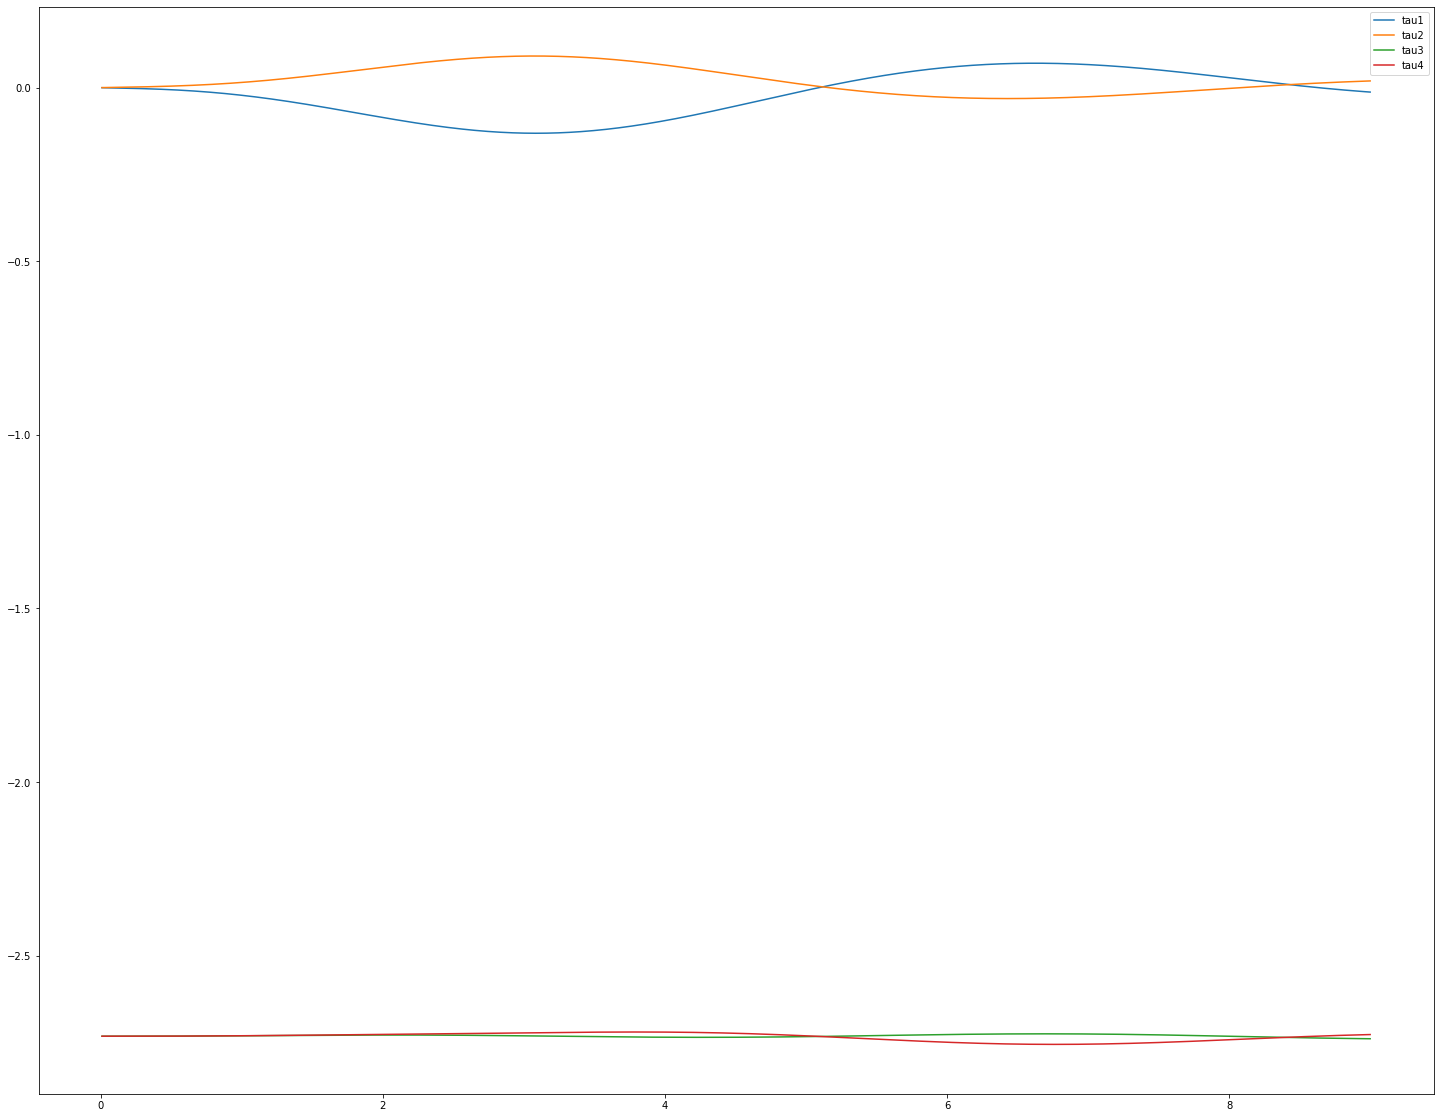

In [107]:
plt.plot(tt[1:900], ttau1[1:900], label="tau1")
plt.plot(tt[1:900], ttau2[1:900], label="tau2")
plt.plot(tt[1:900], ttau3[1:900], label="tau3")
plt.plot(tt[1:900], ttau4[1:900], label="tau4")
plt.legend()

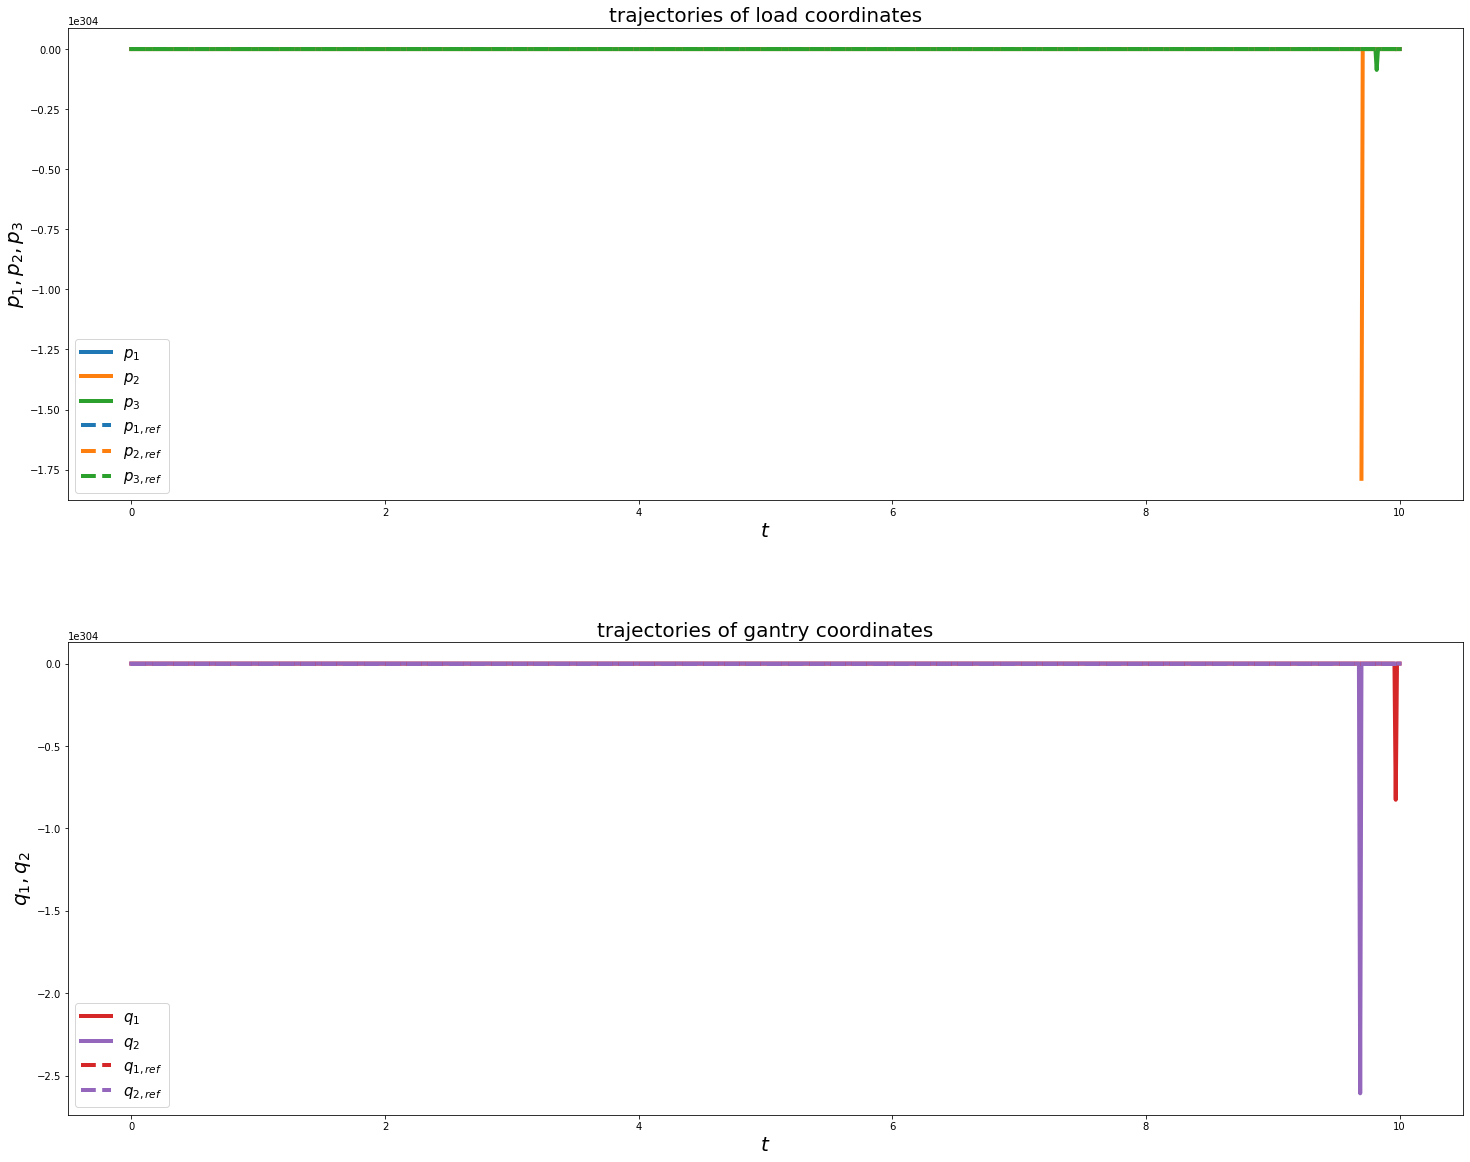

In [108]:
plt.rcParams['figure.figsize'] = [25, 20]
fig, axs = plt.subplots(2, 1)
plt.subplots_adjust(hspace = 0.3)

axs[0].plot(tt[:1000], res[:1000, 0], '#1f77b4', label=r'$p_{1}$', linewidth=4.0)
axs[0].plot(tt[:1000], res[:1000, 1], '#ff7f0e', label=r'$p_{2}$', linewidth=4.0)
axs[0].plot(tt[:1000], res[:1000, 2], '#2ca02c', label=r'$p_{3}$', linewidth=4.0)
axs[0].plot(tt[:1000], p1_traj_func(tt[:1000]), '#1f77b4', linestyle='--', label=r'$p_{1,ref}$', linewidth=4.0)
axs[0].plot(tt[:1000], p2_traj_func(tt[:1000]), '#ff7f0e', linestyle='--', label=r'$p_{2,ref}$', linewidth=4.0)
axs[0].plot(tt[:1000], p3_traj_func(tt[:1000]), '#2ca02c', linestyle='--', label=r'$p_{3,ref}$', linewidth=4.0)

axs[0].legend(prop={'size': 15})
axs[0].set_title('trajectories of load coordinates', fontsize=20)
axs[0].set_xlabel('$t$', fontsize=20)
axs[0].set_ylabel('$p_1, p_2, p_3$', fontsize=20)

axs[1].plot(tt[:1000], res[:1000, 3], '#d62728', label=r'$q_{1}$', linewidth=4.0)
axs[1].plot(tt[:1000], res[:1000, 4], '#9467bd', label=r'$q_{2}$', linewidth=4.0)
axs[1].plot(tt[:1000], q1_traj_func(tt[:1000]), '#d62728', linestyle='--', label=r'$q_{1,ref}$', linewidth=4.0)
axs[1].plot(tt[:1000], q2_traj_func(tt[:1000]), '#9467bd', linestyle='--', label=r'$q_{2,ref}$', linewidth=4.0)

axs[1].legend(prop={'size': 15})
axs[1].set_title('trajectories of gantry coordinates', fontsize=20)
axs[1].set_xlabel('$t$', fontsize=20)
axs[1].set_ylabel('$q_1, q_2$', fontsize=20)

plt.show()

### Stability analysis of current trajectories

In [322]:
xref, error, errord = sp.symbols('x_{ref} e_x \dot{e}_x')

In [323]:
eetheta = st.symb_vector("e1:{0}".format(len(ttheta)+1)) ##:T
eethetad = st.time_deriv(eetheta, eetheta, order=1) ##:T 
eethetadd = st.time_deriv(eetheta, eetheta, order=2) ##:T 

xxref = st.row_stack(ref_states, ref_states_d) ##:T
xxrefd = st.row_stack(ref_states_d, ref_states_dd) ##:T
eerror = st.row_stack(eetheta, eethetad) ##:T
eerrord = st.row_stack(eethetad, eethetadd) ##:T

st.make_global(xxref, xxrefd, eerror, eerrord)

eetheta.T := [e₁  e₂  e₃  e₄  e₅]

---

eethetad.T := [ė₁  ė₂  ė₃  ė₄  ė₅]

---

eethetadd.T := [ë₁  ë₂  ë₃  ë₄  ë₅]

---

xxref.T := [pr₁  pr₂  pr₃  qr₁  qr₂  pṙ₁  pṙ₂  pṙ₃  qṙ₁  qṙ₂]

---

xxrefd.T := [pṙ₁  pṙ₂  pṙ₃  qṙ₁  qṙ₂  pr̈₁  pr̈₂  pr̈₃  qr̈₁  qr̈₂]

---

eerror.T := [e₁  e₂  e₃  e₄  e₅  ė₁  ė₂  ė₃  ė₄  ė₅]

---

eerrord.T := [ė₁  ė₂  ė₃  ė₄  ė₅  ë₁  ë₂  ë₃  ë₄  ë₅]

---

In [325]:
# place current controller functions here:
tau_control = sp.Matrix([flat_tau1_control_pseudo, flat_tau2_control_pseudo, flat_tau3_control_pseudo, flat_tau4_control_pseudo])

In [326]:
xx = eerror + xxref
ffex = mod.f.subz([*ttheta, *tthetad], [*xx]).smplf + mod.g.subz([*ttheta, *tthetad], [*xx]).smplf * tau_control.subz([*meas_states, *meas_states_d], [*xx]) - xxrefd

In [327]:
P = sp.eye(10)
Vdot = (xx.T * P * ffex)[0] ## = w(ex, t)

In [328]:
ffex0 = ffex.subz0(eerror)

In [329]:
ffex0.co

⎡ 0  ⎤
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢ 0  ⎥
⎢    ⎥
⎢3693⎥
⎢    ⎥
⎢3691⎥
⎢    ⎥
⎢3705⎥
⎢    ⎥
⎢3737⎥
⎢    ⎥
⎣3729⎦

In [330]:
jacobi = ffex.jacobian(eerror)
jacobi0 = jacobi.subz0(eerror)

In [331]:
jacobi0.s ##:
jacobi0.co ##:

---

(jacobi0.co) := ⎡ 0     0     0     0     0     1     0     0    0  0⎤
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     1     0    0  0⎥
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     0     1    0  0⎥
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     0     0    1  0⎥
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     0     0    0  1⎥
⎢                                                    ⎥
⎢8635  4949  8675  3694  3681  1254  1251  1268  0  0⎥
⎢                                                    ⎥
⎢4948  8624  8669  1853  1847  1251  1248  1265  0  0⎥
⎢                                                    ⎥
⎢8665  8660  8716  3707  3696  1265  1262  1279  0  0⎥
⎢                                                    ⎥
⎢4946  3103  4975  3699   0    1255  1253  1267  2  0⎥
⎢                                                

---

In [332]:
hesse = sp.hessian(Vdot, eerror)
hesse0 = hesse.subz0(eerror)

In [333]:
hesse0.co

⎡49559  49623  74710  26648  26584  17443  13734  17570  4946  4931⎤
⎢                                                                  ⎥
⎢49623  44572  73410  21083  21029  12509  16167  16304  3103  3094⎥
⎢                                                                  ⎥
⎢74710  73410  69955  32331  32265  18835  18805  18989  4975  4965⎥
⎢                                                                  ⎥
⎢26648  21083  32331  20408    0    8102   6254   8156   3698   0  ⎥
⎢                                                                  ⎥
⎢26584  21029  32265    0    20356  8084   6236   8155    0    3686⎥
⎢                                                                  ⎥
⎢17443  12509  18835  8102   8084   1254   2501   2532   1255  1253⎥
⎢                                                                  ⎥
⎢13734  16167  18805  6254   6236   2501   1248   2526   1253  1249⎥
⎢                                                                  ⎥
⎢17570  16304  18989  8156   8155 

First look if error dynamics is 0 for equilibrium in $t = 0, 10$

In [334]:
ffex0_num = ffex0.subs(sys_params)
ffex0_num = ffex0_num.subz(flat_quantities, flat_quant_subs)

In [335]:
ffex0_num_t0 = ffex0_num.subs(t, 0) 
ffex0_num_t0 ##:
ffex0_num_t10 = ffex0_num.subs(t, 10)
ffex0_num_t10 ##:

(ffex0_num_t0) := ⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢-5.32907051820075e-15⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎣          0          ⎦

---

(ffex0_num_t10) := ⎡          0          ⎤
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢          0          ⎥
⎢                     ⎥
⎢4.02178290670463e-14 ⎥
⎢                     ⎥
⎢-1.26121335597418e-13⎥
⎢                     ⎥
⎢-1.4210854715202e-14 ⎥
⎢                     ⎥
⎢3.75699999761891e-18 ⎥
⎢                     ⎥
⎣1.76586886695218e-17 ⎦

---

#### Lyapunov's indirect (1st) method

In [336]:
jacobi_num = jacobi0.subs(sys_params)
#jacobi_num = jacobi_num.subz(flat_quantities, flat_quant_subs)

In [337]:
jacobi_num.co

⎡ 0     0     0     0     0     1     0     0    0  0⎤
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     1     0    0  0⎥
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     0     1    0  0⎥
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     0     0    1  0⎥
⎢                                                    ⎥
⎢ 0     0     0     0     0     0     0     0    0  1⎥
⎢                                                    ⎥
⎢7987  4577  8017  3416  3403  1160  1157  1170  0  0⎥
⎢                                                    ⎥
⎢4576  7976  8011  1713  1707  1157  1154  1167  0  0⎥
⎢                                                    ⎥
⎢8007  8002  8054  3425  3414  1169  1166  1179  0  0⎥
⎢                                                    ⎥
⎢4576  2871  4598  3421   0    1161  1159  1169  2  0⎥
⎢                                                    ⎥
⎣4561  286

In [338]:
tti = npy.arange(0.1, 10.1, 0.1)
eigs = []

In [339]:
for ti in tti:
    flat_quant_subs_num = [flats.subs(t, ti) for flats in flat_quant_subs]
    jacobi_num_ti = jacobi_num.subz(flat_quantities, flat_quant_subs_num)
    jacobi_num_ti_eigs = npy.linalg.eig(st.to_np(jacobi_num_ti))
    eigs.append(jacobi_num_ti_eigs[0].real)

In [340]:
eigs

[array([-0.37939454, -0.37939454, -1.        , -1.        , -0.62060546, -0.62060546, -0.99999999, -1.00000001, -1.        , -1.        ]),
 array([-0.37939452, -0.37939452, -1.        , -1.        , -0.62060548, -0.62060548, -1.        , -1.        , -1.        , -1.        ]),
 array([-0.37939449, -0.37939449, -1.        , -1.        , -0.62060551, -0.62060551, -1.        , -1.        , -1.00000006, -0.99999994]),
 array([-0.37939447, -0.37939447, -1.        , -1.        , -0.62060554, -0.62060554, -1.        , -1.        , -1.        , -1.        ]),
 array([-0.3793945 , -0.3793945 , -1.        , -1.        , -0.62060553, -0.62060553, -0.99999996, -0.99999996, -0.99999999, -1.00000001]),
 array([-0.37939475, -0.37939475, -1.        , -1.        , -0.62060551, -0.62060551, -0.99999974, -0.99999974, -0.99999999, -1.00000001]),
 array([-0.37939543, -0.37939543, -1.        , -1.        , -0.6206057 , -0.6206057 , -0.99999887, -0.99999887, -1.00000007, -0.99999993]),
 array([-0.37939692,

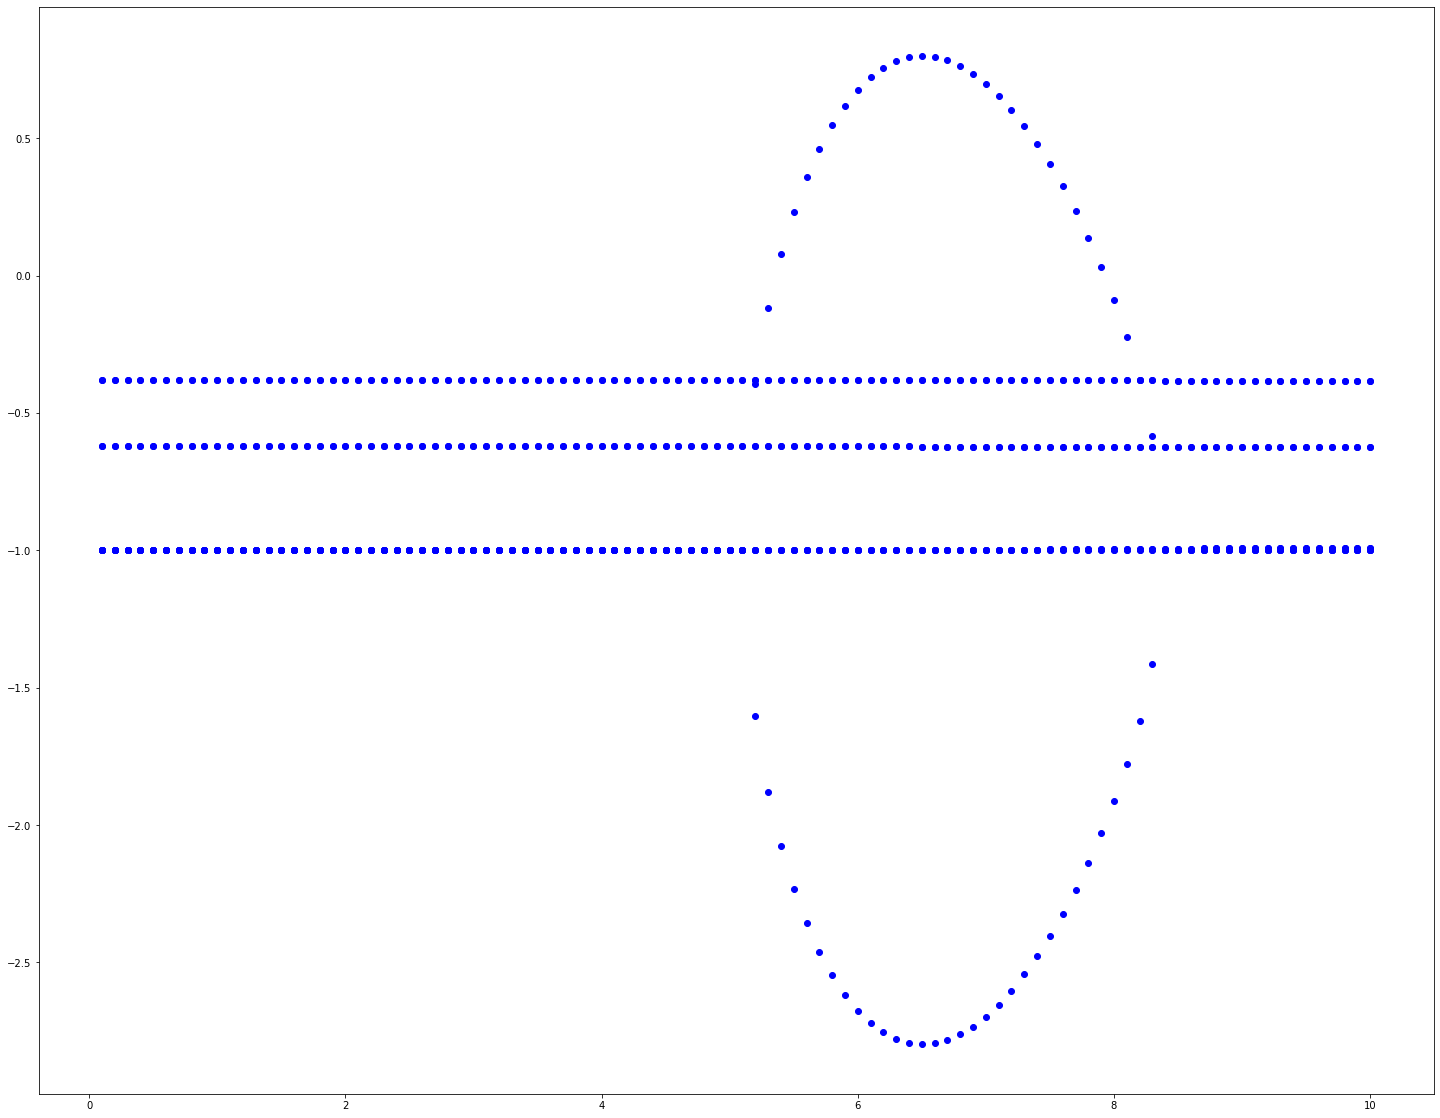

In [341]:
plt.plot(tti, eigs, "bo")

#### Lyapunov's direct (2nd) method

In [71]:
# load with pickle
#pickle_data = {"Vdot":Vdot, "Vdot_traj":Vdot_traj, "Vdot_traj_num":Vdot_traj_num, "hesse": hesse, "hesse0": hesse0}

load_hesse = 1

if load_hesse == 1:
    with open("hesse_matrix.pcl", "rb") as pfile:
        data = pickle.load(pfile)
        locals().update(data)

else:
    Vdot_traj = Vdot.subz(flat_quantities, flat_quant_subs)
    Vdot_traj_num = Vdot_traj.subs(sys_params)
    hesse = sp.hessian(Vdot_traj_num, eerror)
    hesse0 = hesse.subz0(eerror)

In [74]:
Vdot0 = Vdot_traj_num.subz0(eerror)

In [76]:
Vdot0i = []

for ti in tti:
    Vdot0i.append(Vdot0.subs(t, ti))

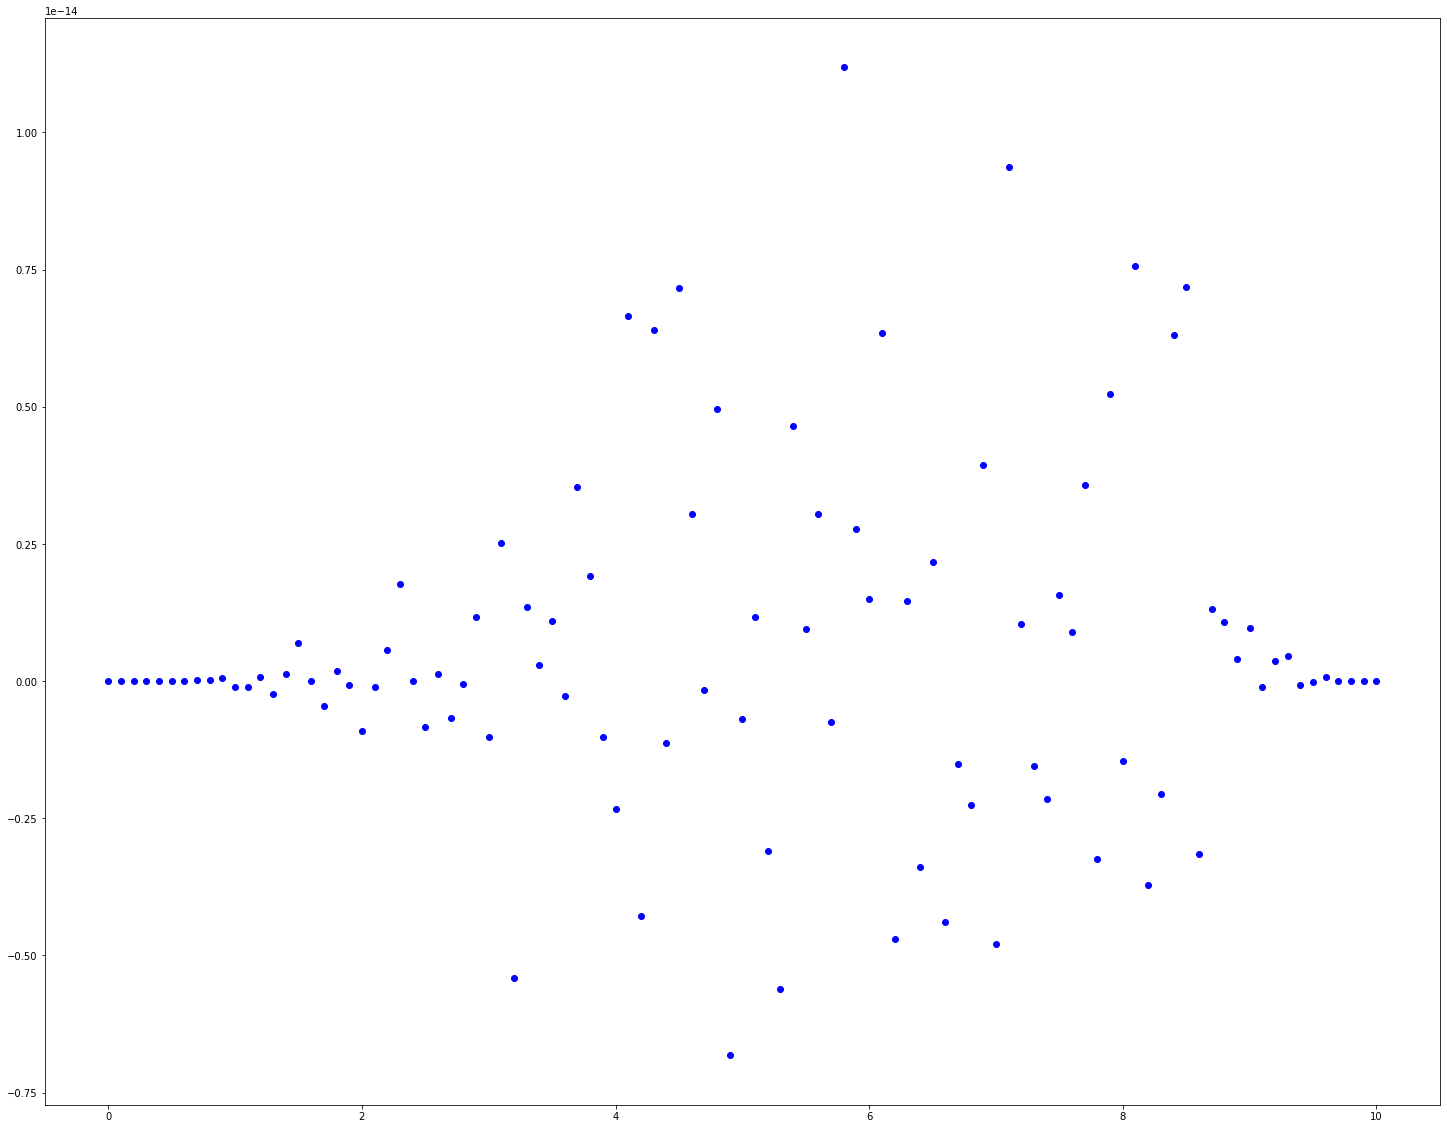

In [77]:
plt.plot(tti, Vdot0i, "bo")

In [44]:
%%time
hesse0ti = hesse0.subs(t, 10).evalf()

CPU times: user 587 ms, sys: 0 ns, total: 587 ms
Wall time: 585 ms


In [45]:
hesse0ti_eigs = npy.linalg.eig(st.to_np(hesse0ti))[0]

In [46]:
npy.real(hesse0ti_eigs)

array([ 7.50162648e+01, -7.90073165e+01,  1.39859309e+01, -1.59068925e+01, -2.15921161e+00, -4.06778876e+00,  7.30182435e-02,  6.59954628e-02, -4.00000000e+00,  5.55045920e-16])

#### V, Vdot development for simulated trajectory

In [204]:
error_traj = npy.array([err_trajp1, err_trajp2, err_trajp3, err_trajq1, err_trajq2, err_trajpdot1, err_trajpdot2, err_trajpdot3, err_trajqdot1, err_trajqdot2])

In [221]:
V_traj = []
for i in range(0, len(error_traj)):
    V_traj = 0.5 * npy.square(error_traj[i, :])

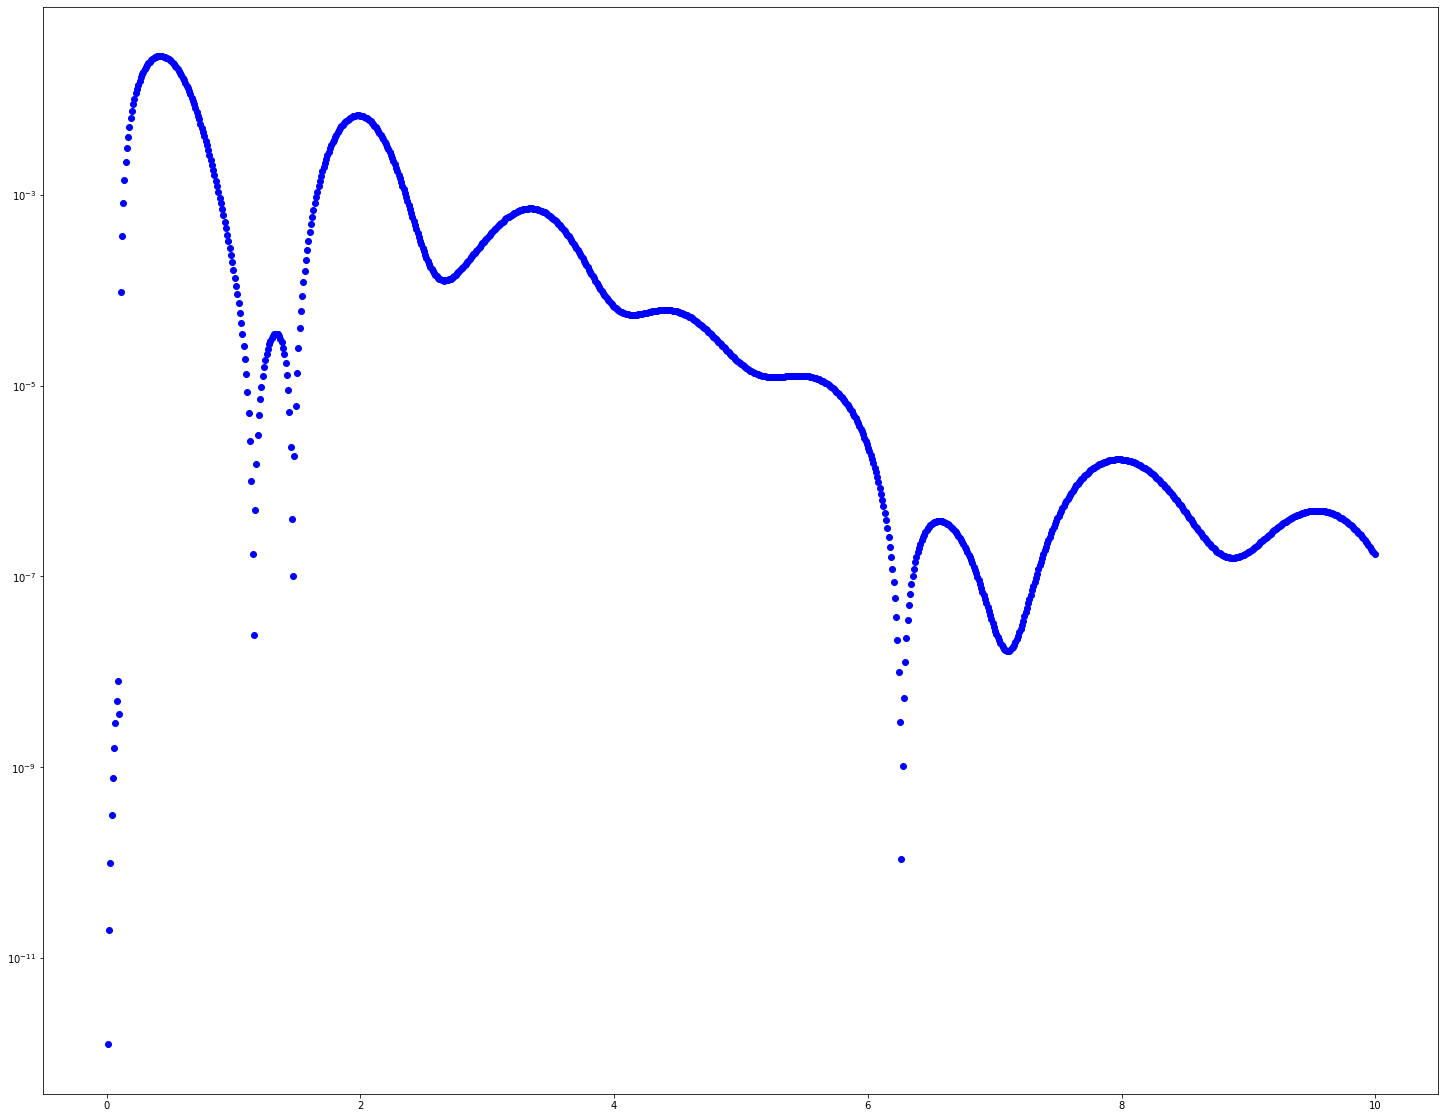

In [230]:
plt.semilogy(tt[:1000], V_traj, "bo")

In [ ]:
joint_pos_expr = st.col_stack(G1, G3, G4, G6).subs(sys_params) ##:
joint_pos_func = st.expr_to_func(mod.tt, joint_pos_expr, keep_shape=True)

In [ ]:
import matplotlib.animation as animation
from IPython.display import HTML

fig = pl.figure() 
ax = fig.add_subplot(111, autoscale_on=False, xlim=(-2.3,2.3), ylim=(-2.3,2.3))
ax.set_aspect('equal')

line, = ax.plot([],[],'o-', lw=2)
time_template = 'time=%.1fs'
time_text = ax.text(0.05, 0.9, '', transform=ax.transAxes)
dt = tt[1] - tt[0]


def init():
    line.set_data([],[])
    time_text.set_text('')
    return line, time_text

l1 =1.0

def animate(i):
    xx, yy = joint_pos_func(*res[i, :res.shape[1]//2])
    
    line.set_data(xx,yy)
    time_text.set_text(time_template%(i*dt))
    
    return line, time_text


ani = animation.FuncAnimation(fig, animate, range(res.shape[0]), interval=tt[-1]*3, blit=True, init_func=init)


# this animation is nice but results in a big notebook file which is unwanted for publication in the repo
HTML(ani.to_jshtml())



